# Image-Segmenation-on-CityScapes-dataset

This PyTorch script aims to train a SegmentationModel for Road Scene segmentation task using the CityScapes dataset, with all required files pre-uploaded on Google Drive as a zip file. The code covers essential tasks such as dataset extraction, data loading, and model training, utilizing the DeepLabV3Plus architecture with a resnet34 encoder.

> The segmentation steps are given below:<br>


1.   Data Prepration
2.   Data Transformation
3.   Custom Dataset Class
4.   Segmentation Model
5.   Training and Evaluation Functions
6.   Training Loop



Before Starting with the Project we need to collect data from Google Drive

### Mounting Google Drive and Installing Dependencies:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import glob
import zipfile
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=89f3c61e82a0a5e2577ef7890ba89a8c7c9dce887427cfc918fb8f1ddf918692
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a862adf16dafaa515eea546edaf1e21ebe30b805e9ebd96052c0d57483c32af9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


### 1. Data Prepration
* CityScapes dataset is extracted from a zip file.
* Parameters such as the number of epochs, learning rate, encoder type, device, batch size, and image size are set.

In [3]:
zip_ref= zipfile.ZipFile("/content/drive/MyDrive/CityScapes.zip",'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [4]:
cityscapes = '/content/dataset/CityScapes'
path_data = cityscapes

In [5]:
train_image_dir = f'{path_data}/leftImg8bit_trainvaltest/leftImg8bit/train/*/*'
train_mask_dir = f'{path_data}/Output/gtFine/train/*/*'

val_image_dir = f'{path_data}/leftImg8bit_trainvaltest/leftImg8bit/val/*/*'
val_mask_dir = f'{path_data}/Output/gtFine/val/*/*'

### 2. Initializing variables

In [6]:
Epochs = 20
learning_rate = 0.001
encoder = 'resnet34'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 4
img_size = (256,512)

### 3. Data Transformation

In [7]:
def get_train_trans():
  return transforms.Compose([
      transforms.Resize(img_size, interpolation=Image.BILINEAR),
      transforms.ToTensor(),
  ])

def get_valid_trans():
  return transforms.Compose([
      transforms.Resize(img_size, interpolation=Image.BILINEAR),
      transforms.ToTensor(),
  ])

### 4. Custom Dataset Class
* A custom dataset class (CustomDataset) is defined, which inherits from torch.
utils.data.Dataset.
* The class handles loading and transforming images and masks.

In [8]:
class CustomDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transform=None):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transform = transform

    self.images = glob.glob(self.img_dir)
    self.images = sorted(self.images)

    self.masks = glob.glob(self.mask_dir)
    self.masks = sorted(self.masks)

  def __getitem__(self, index):
    image, mask = self.images[index], self.masks[index]
    image = Image.open(image).convert("RGB")
    mask = Image.open(mask).convert("L")

    if self.transform:
      image = self.transform(image)
      mask = self.transform(mask)

    return image, mask

  def __len__(self):
    return len(self.images)

In [9]:
trainset = CustomDataset(train_image_dir, train_mask_dir, get_train_trans())
validset = CustomDataset(val_image_dir, val_mask_dir, get_valid_trans())

In [10]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=batch_size)

### 5. Segmentation Model
* The segmentation model is defined as a class (SegmentationModel) inheriting from torch.nn.Module.
* The model uses the DeepLabV3Plus architecture from the segmentation models library, with a specified encoder and activation function.

In [11]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.DeepLabV3Plus(
        encoder_name = encoder,
        in_channels= 3,
        classes=1,
        activation=None
    )
    self.activation = nn.Sigmoid()
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks is not None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return self.activation(logits)

In [12]:
model = SegmentationModel()
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 212MB/s]


### 6. Training and Evaluation Functions:
* Functions for training (train_fn) and evaluation (eval_fn) are defined.
* Training involves iterating through batches, calculating and backpropagating the loss, and updating the model parameters.
*Evaluation is similar but without backpropagation.

In [13]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(data_loader)

In [14]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  return total_loss / len(data_loader)

### 7. Training Loop
* The main training loop runs for the specified number of epochs.
* Training and validation losses are recorded for each epoch.
* The model with the best validation loss is saved.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_valid_loss = np.Inf
train_losses = []
valid_losses = []

for i in range(Epochs):
    print(f"Epoch: {i+1}")
    train_loss = train_fn(train_loader, model, optimizer)
    valid_loss = eval_fn(val_loader, model)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f}")

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'road_scene_ImgSeg_model.pt')
        print('Model Saved!')
        best_valid_loss = valid_loss
    print('\n')

### Plot the training loss

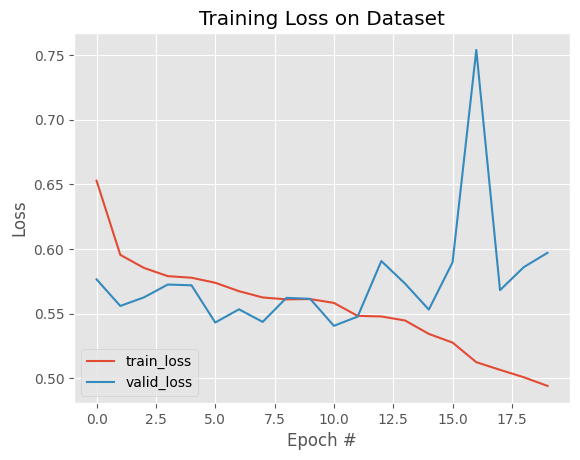

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(valid_losses, label="valid_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")